# Mean Reverting
- when price moves too far from some avg/trend
- how far is too far?
    - when price_actual is 5% from price_predicted

data <== ccxt <br>
predictions <== ffnn lin_reg <br>
10 ma (10 mins)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import torch
import torch.nn as nn
import torch.optim as optim
from cpl.data.processor_binance import BinanceProcessor

In [2]:
ticker_list = ["BTCUSDT","ETHUSDT"]
start_date = "2021-12-01"
end_date = "2021-12-31"
time_interval = "1m"

In [3]:
p = BinanceProcessor("binance")
raw = p.download_data(ticker_list, start_date, end_date, time_interval)

In [4]:
raw.head()

,time,open,high,low,close,volume,adj_close,tic
0,2021-12-01 00:00:00,56782.00,56817.36,56780.00,56782.00,17.52761,56782.00,BTCUSDT
1,2021-12-01 00:01:00,56782.00,56813.51,56740.00,56755.50,39.00328,56755.50,BTCUSDT
2,2021-12-01 00:02:00,56755.49,56755.50,56712.21,56720.84,23.64537,56720.84,BTCUSDT
3,2021-12-01 00:03:00,56720.83,56749.73,56712.22,56720.01,17.43134,56720.01,BTCUSDT
4,2021-12-01 00:04:00,56717.01,56727.62,56700.00,56714.45,19.49503,56714.45,BTCUSDT


In [5]:
proc1 = raw[["time", "close"]]
proc1["ma10"] = proc1['close'].rolling(10).mean()
proc1["ratio"] = proc1['close'] / proc1['ma10']
proc1.dropna(inplace=True)
proc1.tail()

,time,close,ma10,ratio
994,2021-12-30 13:34:00,3758.89,3757.721,1.000311
995,2021-12-30 13:35:00,3758.15,3758.057,1.000025
996,2021-12-30 13:36:00,3759.05,3758.496,1.000147
997,2021-12-30 13:37:00,3757.75,3758.459,0.999811
998,2021-12-30 13:38:00,3759.76,3758.867,1.000238


In [6]:
#check that ratio ~ 1
proc1['ratio'].describe()

count    41989.000000
mean         0.999794
std          0.011778
min          0.108074
25%          0.999153
50%          1.000023
75%          1.000859
max          1.046472
Name: ratio, dtype: float64

In [7]:
proc1.set_index('time', inplace=True)

In [8]:
proc1['day'] = pd.to_datetime(proc1.index).day

In [9]:
proc1.tail()

,close,ma10,ratio,day
time,,,,
2021-12-30 13:34:00,3758.89,3757.721,1.000311,30
2021-12-30 13:35:00,3758.15,3758.057,1.000025,30
2021-12-30 13:36:00,3759.05,3758.496,1.000147,30
2021-12-30 13:37:00,3757.75,3758.459,0.999811,30
2021-12-30 13:38:00,3759.76,3758.867,1.000238,30


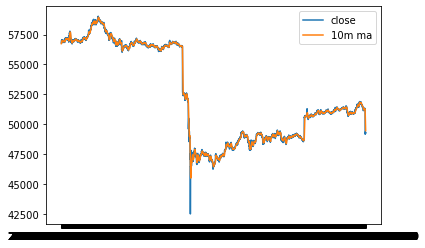

In [10]:
#plot close price, ma 
plt.plot(proc1.index[:5000], proc1['close'][:5000], label = "close")
plt.plot(proc1.index[:5000], proc1['ma10'][:5000], label = "10m ma")
plt.legend() 
plt.show()

In [11]:
class LSTMPredictor(nn.Module):
    def __init__(self, dims):
        super(LSTMPredictor, self).__init__()
        self.dims = dims
        #lstm1, lstm2, linear layer
        self.lstm1 = nn.LSTMCell(1, self.dims)
        self.lstm2 = nn.LSTMCell(self.dims, self.dims)
        self.linear = nn.Linear(self.dims, 1)
    
    def forward(self, x, horizon=0):
        #horizon = 0 just trains, > 0 means predict next n
        outputs = []
        n_samples = x.size(0)
        #initial hidden state
        h_t1 = torch.zeros(n_samples, self.dims, dtype=torch.float32)
        #initial cell state
        c_t1 = torch.zeros(n_samples, self.dims, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.dims, dtype=torch.float32)
        #initial cell state
        c_t2 = torch.zeros(n_samples, self.dims, dtype=torch.float32)
        
        chunk_size = 1
        for input_t in x.split(chunk_size, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm1(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm1(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        outputs = torch.cat(outputs,  dim=1)
        return outputs
                

In [14]:
proc1['close'][:5000].to_numpy().shape

(5000,)

In [16]:
horizon = 1 #(off set by one. this price predict next price)

In [17]:
train_X = proc1['close'][:5000].to_numpy()
train_Y = proc1['close'][horizon:5000+horizon].to_numpy()
# test_X
# test_Y

In [18]:
train_X

array([56820.  , 56913.92, 56937.48, ..., 49269.64, 49236.35, 49259.66])

In [19]:
train_Y

array([56913.92, 56937.48, 56977.7 , ..., 49236.35, 49259.66, 49251.05])

In [22]:
model = LSTMPredictor(1)
criterion = nn.MSELoss()
#limited memory bfgs, requires a function as an input
optimizer = optim.LBFGS(model.parameters(), lr=0.8)
n_steps = 100
for i in range(n_steps):
    print("Cur Step: ", i)
    
    # for the optimizer
    def closure():
        optimizer.zero_grad()
        out = model(train_X)
        loss = criterion(out, train_Y)
        print("training loss: ", loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    
    #do predictions
    with torch.no_grad():
        future = 1000
        pred = model.predict(test_X, future=future)
        #exclude future values
        loss = criterion(pred[:,:-future], test_Y)
        print("test loss: ", loss.item())
        y = pred.detach().numpy()
        
    #plot
    

Cur Step:  0


TypeError: 'int' object is not callable